<a href="https://colab.research.google.com/github/gudaykiran/S15-DenseNet-for-DepthMap-and-Mask-Image-Prediction-without-using-Pretrained-Model/blob/master/Session15b_Model2_sample1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executed Time

In [0]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-05-25 08:34:50.566860
Current Date/Time:  2020-05-25 08:34:51.262625


# Mounting Gdrive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Installing SSIM Loss package

In [0]:
%matplotlib inline
!pip install git+https://github.com/arraiyopensource/kornia

  Cloning https://github.com/arraiyopensource/kornia to /tmp/pip-req-build-6bp4htdf
  Running command git clone -q https://github.com/arraiyopensource/kornia /tmp/pip-req-build-6bp4htdf
  Created wheel for kornia: filename=kornia-0.3.2+df93618-py2.py3-none-any.whl size=174640 sha256=00c2f988749b0eba3f6ba7c2a6d4fde45ecd621323dfd3e40c301db42e87340f
  Stored in directory: /tmp/pip-ephem-wheel-cache-pmhmdlky/wheels/a0/47/86/854e2f9a801b368f296cb25f167cbd56aa805f974b15421a67
Successfully built kornia


# Importing all other necessary packages

In [0]:
import torch
import json
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook, tnrange
import numpy as np
import matplotlib.pyplot as plt
import io
from itertools import groupby
import cv2
from tqdm.auto import tqdm
from pathlib import Path
from time import time
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset , random_split
from PIL import Image
from torchvision.transforms import transforms
import os
from glob import glob
import torch
import torchvision
from torch import nn
from kornia.losses import SSIM

In [0]:
%cd /content/gdrive/My Drive/EVA4/S15/Dataset/fg_bg Images

/content/gdrive/My Drive/EVA4/S15/Dataset/fg_bg Images


In [0]:
BG_DIR = '/content/gdrive/My Drive/EVA4/S15/Dataset/fg_bg Images/Bg'
BGFG_DIR = '/content/gdrive/My Drive/EVA4/S15/Dataset/fg_bg Images/Bg_Fg-sample1'
MASK_DIR = '/content/gdrive/My Drive/EVA4/S15/Dataset/fg_bg Images/Bg_Fg_Masks-sample1'
DEPTH_DIR = '/content/gdrive/My Drive/EVA4/S15/Dataset/fg_bg Images/Depth-sample 1'

# Retrieving Files

In [0]:
def getfiles(path= "/content/gdrive/My Drive/EVA4/S15/Dataset/fg_bg Images/"):
    files_list = []
    
    files_list.extend(glob(os.path.join(os.path.join(path + str(), '*.jpg'))))
    #files_list.extend(glob(os.path.join(os.path.join(path + str(), '*.jpeg'))))
    print("Total No of images are:  " + str(len(files_list)))
    return files_list

In [0]:
bg_files= getfiles(BG_DIR)
bgfg_files= getfiles(BGFG_DIR)
mask_files= getfiles(MASK_DIR)
depth_files = getfiles(DEPTH_DIR)

Total No of images are:  100
Total No of images are:  8000
Total No of images are:  8000
Total No of images are:  8000


# Data Transformations

In [0]:
from torchvision import datasets, transforms
import numpy as np

channel_means = ([0.5643, 0.5261, 0.4895])
channel_stdevs = ([0.2161, 0.2144, 0.2149])
# Train Phase transformations
#mean, std = torch.tensor([0.5,0.5,0.5])*255,torch.tensor([0.2,0.2,0.2])*255
train_transform = transforms.Compose([
                                       transforms.Resize((128,128)),
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor()
])


fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = transforms.Compose([transforms.Normalize(mean=channel_means, std=channel_stdevs)])

# Importing Dataset (MsDepDataset)

In [0]:
from msdepdataset import MsDepDataset
train_set = MsDepDataset(train_transform, bg_files, bgfg_files, mask_files,depth_files)


# DataLoaders

In [0]:
import dataloader
trainloader = DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)
sample = next( iter(trainloader))
type(sample)

# test dataloader
#testloader = DataLoader(test, batch_size=16, shuffle=True, pin_memory=True)

dict

In [0]:
[(k, v.shape) for k,v in sample.items()]

[('bg_image', torch.Size([16, 3, 128, 128])),
 ('bgfg_image', torch.Size([16, 3, 128, 128])),
 ('mask_image', torch.Size([16, 3, 128, 128])),
 ('depth_image', torch.Size([16, 3, 128, 128]))]

In [0]:
imgs = sample["bgfg_image"]

In [0]:
grid_tensor = torchvision.utils.make_grid(imgs,2)
grid_image = grid_tensor.permute(1,2,0)

# Showing Images

In [0]:
def show(tensors, figsize=(10,10), *args, **kwargs):
  try:
    tensors = tensors.detach().cpu()
  except: 
    pass
  grid_tensors= torchvision.utils.make_grid(tensors,*args, **kwargs)
  grid_image= grid_tensors.permute(1,2,0)
  plt.figure(figsize=figsize)
  plt.imshow(grid_image)
  plt.xticks([])
  plt.yticks([])
  plt.show()

def show_pred(tensors,*args, **kwargs):
  tensors= (tensors * std[None, :, None, None])+ mean[None, : , None, None]
  show(tensors, *args, **kwargs)

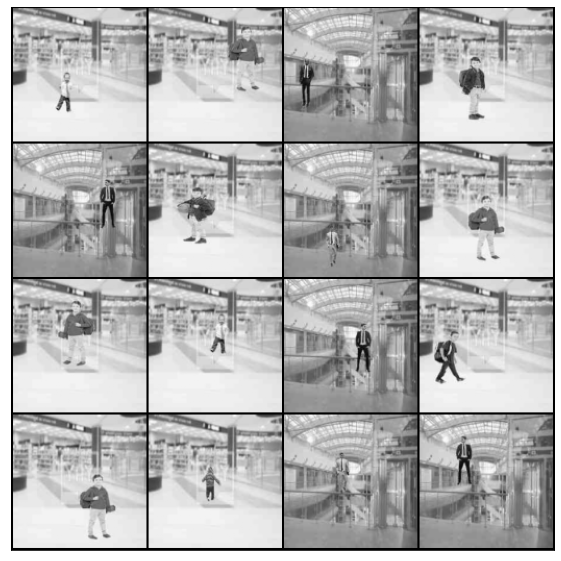

In [0]:
show(imgs, nrow=4)

# Model and Parameters

In [0]:
from torchsummary import summary
from net import Net
model= Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model= model.to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1977280


# Summarizes Model by trainable parameters and weights

In [0]:
from torch.nn.modules.module import _addindent
import torch
import numpy as np
def torch_summarize(model, show_weights=True, show_parameters=True):
   
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)
        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])
        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'
    tmpstr = tmpstr + ')'
    return tmpstr

# Loss functions

In [0]:
criterion1 = nn.BCEWithLogitsLoss()
criterion2 = SSIM(3, reduction="mean" )
optim = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

# Saving the model for certain sample of images

In [0]:
PATH= Path('/content/gdrive/My Drive/EVA4/S15/Dataset/Model_Save/Save1/')
PATH.mkdir(exist_ok= True)

In [0]:
def draw_save(tensors, name, figsize=(50,50), *args, **kwargs):
  try:
    tensors = tensors.detach().cpu()
  except: 
    pass
  grid_tensor1= torchvision.utils.make_grid(tensors,*args, **kwargs)
  grid_image1= grid_tensor1.permute(1,2,0)
  plt.figure(figsize=figsize)
  plt.imshow(grid_image1)
  plt.xticks([])
  plt.yticks([])
  plt.savefig(name, bbox_inches = 'tight')
  plt.show()

# Training the Model

In [0]:
def train( model, criterion1,criterion2, device, trainloader, optimizer, epoch):
  model.train()
  pbar = tqdm(trainloader)
  for batch_idx, data in enumerate(pbar):
    data["bg_image"] = data["bg_image"].to(device)
    data["bgfg_image"] = data["bgfg_image"].to(device)
    data["mask_image"] = data["mask_image"].to(device)
    data["depth_image"] = data["depth_image"].to(device)
    optimizer.zero_grad()
    output=model(data)    
    
    loss1 = criterion1(output[0],data["mask_image"])
    loss2 = criterion2(output[1],data["depth_image"])
    loss = 2*loss1 + loss2
    pbar.set_description(desc= f'l1={round(loss1.item(),4)} l2={round(loss2.item(),4)}')
    loss.backward()
    optimizer.step()
    if batch_idx % 50 == 0:
      print('Train Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,batch_idx*len(data),len(trainloader.dataset), 
                                                                      100.*batch_idx/len(trainloader), loss.item()))
    if batch_idx % 499 == 0:
      draw_save(output[0], PATH/f"/{epoch}_SSIM_BCE_{batch_idx}_PMS_{loss1.item()}.jpg")
      draw_save(output[1], PATH/f"/{epoch}__SSIM_BCE_{batch_idx}_PDP_{loss2.item()}.jpg")
      draw_save(data["mask_image"], PATH/f"/{epoch}__SSIM_BCE_{batch_idx}_MS_{loss.item()}.jpg")
      draw_save(data["depth_image"], PATH/f"/{epoch}__SSIM_BCE_{batch_idx}_DP_{loss.item()}.jpg")
      draw_save(data["bgfg_image"], PATH/f"/{epoch}__SSIM_BCE_{batch_idx}_BG_{loss.item()}.jpg")

    #if batch_idx % 5000 == 0:
    #  show_pred(output.detach().cpu,nrow=2)
    #  show(output,nrow=4)
    if epoch == 14:
     torch.save(model.state_dict(), PATH/f"model_V1__SSIM_BCE_{epoch}.pth")

In [0]:
from torch.optim.lr_scheduler import StepLR
scheduler= StepLR(optim, step_size=1, gamma= 0.01)

for epoch in range(1,15):
  train(model,criterion1,criterion2,device, trainloader, optim, epoch)
  scheduler.step()

# Submitted by G Uday Kiran